In [30]:
import numpy as np
import matplotlib.pyplot as plt

In [31]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision

Here starts the generation of data points (amount is numpoints).

In [32]:
mean = [0,0]
cov = [[1,0],[0,1]]

In [33]:
def g(z):
    return z/10.0 + z/np.linalg.norm(z)

In [34]:
numpoints = 10000
xdata = np.zeros(numpoints)
ydata = np.zeros(numpoints)
for i in range(numpoints):
    z=np.random.multivariate_normal(mean,cov)
    xdata[i], ydata[i] = g(z)
# Plot unit circle
t=np.linspace(0,2*np.pi,100)
unitcircx = np.cos(t)
unitcircy = np.sin(t)

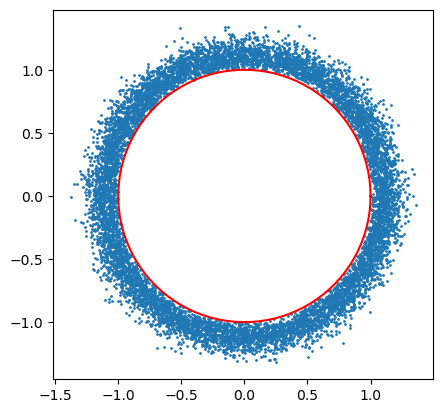

In [35]:
plt.gca().set_aspect('equal')
plt.plot(xdata,ydata,'.',markersize=2)
plt.plot(unitcircx,unitcircy,'r')

In [36]:
data=[]
for i in range(numpoints):
    x=torch.randn(1,2)
    x[0,0]=xdata[i]
    x[0,1]=ydata[i]
    data.append(x)

In [37]:
dataloader = torch.utils.data.DataLoader(data,batch_size=128,shuffle=True)

In [38]:
x1 = next(iter(dataloader))
print(x1.shape)

torch.Size([128, 1, 2])


Here starts the Variational Autoencoder section.

In [39]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [40]:
class Encoder(nn.Module):
    def __init__(self, latent_dims, hidden):
        super(Encoder, self).__init__()
        self.linear0 = nn.Linear(2, hidden[0])
        self.linear1 = nn.Linear(hidden[0], hidden[1])
        self.linear2 = nn.Linear(hidden[1], latent_dims)
        self.linear3 = nn.Linear(hidden[1], latent_dims)
        
    def forward(self, x):
        x = F.relu(self.linear0(x))
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x)
        logvar = self.linear3(x)
        return mu, logvar
    
    #def forward(self, x):
    #    z = F.relu(self.linear0(x))
    #    z = F.relu(self.linear1(z))
    #    z = F.relu(self.linear2(z))
    #    return z

In [41]:
class Decoder(nn.Module):
    def __init__(self, latent_dims,hidden):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, hidden[0])
        self.linear2 = nn.Linear(hidden[0], hidden[1])
        self.linear3 = nn.Linear(hidden[1], hidden[2])
        self.linear4 = nn.Linear(hidden[2], 2)
        
        
    def forward(self, z): 
        out = F.silu(self.linear1(z)) #F.relu(self.linear1(z))
        out = F.silu(self.linear2(out)) #torch.sigmoid(self.linear2(out))
        out = F.silu(self.linear3(out)) #torch.sigmoid(self.linear2(out))
        out = self.linear4(out)
        return out

In [42]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dims,hidden_dims):
        super(Autoencoder, self).__init__()
        self.latent_dims = latent_dims
        self.hidden_dims = hidden_dims
        self.encoder = Encoder(latent_dims,hidden_dims)
        self.decoder = Decoder(latent_dims,hidden_dims)
        self.N = torch.distributions.Normal(0, 1)
    
    def reparam(self, mu, logvar):
        sigma = torch.exp(0.5 * logvar)
        z = mu + sigma*self.N.sample(mu.shape)
        return z
    
    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparam(mu,logvar)
        x_hat = self.decoder(z)
        return x_hat, mu, logvar
    
    #def forward(self, x):
    #    z = self.encoder(x)
    #    mu, logvar = self.decoder(z)
    #    sigma = torch.exp(0.5 * logvar)
    #    conditional_density = torch.distributions.Normal(mu, sigma)
    #    return conditional_density.sample(), mu, logvar
    
    
    def sample(self,num_samples=1, sigma = 1):
        z = sigma*torch.randn(num_samples, self.latent_dims)
        z = z.to(device)
        x_hat = self.decoder(z)
        return x_hat
    
    #def sample(self,num_samples=1,z=None):
    #    if z == None:
    #        z = torch.randn(num_samples, self.latent_dims)
    #    data_mean, data_logvar = self.decoder(z)
    #    data_std = (0.5 * data_logvar).exp()
    #    conditional_density = torch.distributions.Normal(data_mean, data_std)
    #    return conditional_density.sample()


In [47]:
epsilon = 0.33333 #0.9
beta1 = 0.5
beta2 = 30.0
def train(autoencoder, data, epochs=20):
    opt = torch.optim.Adam(autoencoder.parameters(), lr=5e-3) 
    for epoch in range(epochs):
        avg_loss = 0
        i=0.0
        for x in data:
            x = x.to(device) 
            opt.zero_grad()
            x_hat, mu, logvar = autoencoder(x)
            #var = torch.exp(logvar)
            loss1 = ((x - x_hat)**2).sum()
            #loss2 = (var + mu**2 - torch.log(var) - 1/2).sum()
            #loss2 = (logvar.exp() + mu**2 - logvar - 1)
            #loss2 = 0.5*torch.sum(logvar.exp() + mu**2 - logvar - 1, dim = 1)
            loss2 = torch.mean(-0.5 * torch.sum(1 + logvar - mu ** 2 - logvar.exp(), dim = 1), dim = 0).sum()
            #loss = epsilon*loss1 + (1.-epsilon)*loss2
            loss = beta1*loss1 + beta2*loss2
            avg_loss += loss.item()
            i+=1
            loss.backward()
            opt.step()
        avg_loss = avg_loss/i
        print("Epoch:", epoch, "Avg. loss:", avg_loss)
    return autoencoder

In [ ]:
latent_dims = 2
#hidden_dims = [32, 64, 128, 256, 512]
#hidden_dims = [256, 256, 256, 256, 512]
hidden_dims = [32, 32, 32, 32, 32]
autoencoder = Autoencoder(latent_dims,hidden_dims).to(device) # GPU
autoencoder = train(autoencoder, dataloader, epochs=100)

Epoch: 0 Avg. loss: 74.40986353234399
Epoch: 1 Avg. loss: 68.81706037400645
Epoch: 2 Avg. loss: 62.28397813627991
Epoch: 3 Avg. loss: 56.85104877133913
Epoch: 4 Avg. loss: 55.880219761329364
Epoch: 5 Avg. loss: 55.98611179786393
Epoch: 6 Avg. loss: 56.532346073585224


In [40]:
def plot_latent(autoencoder, data):
    plt.gca().set_aspect('equal')
    for i, x in enumerate(data): 
        mu, logvar = autoencoder.encoder(x.to(device))
        z = autoencoder.reparam(mu,logvar)
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[0, 0], z[0, 1],s=5)
        if i > 1000:
            break

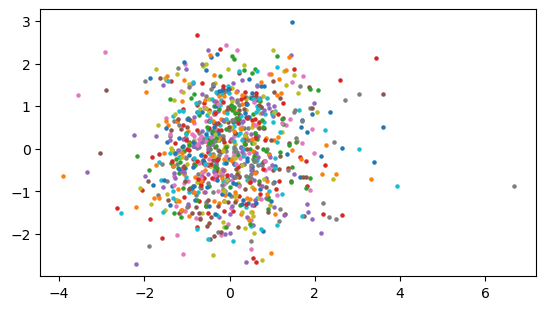

In [41]:
plot_latent(autoencoder, data)

In [42]:
def plot_reconstructed(autoencoder, data):
    x_data=[]
    y_data=[]
    plt.gca().set_aspect('equal')
    for i, x in enumerate(data): 
        mu, logvar = autoencoder.encoder(x.to(device))
        z = autoencoder.reparam(mu,logvar)
        x_hat = autoencoder.decoder(z)
        x_hat = x_hat.to('cpu').detach().numpy()
        #print(x_hat)
        x_data.append(x_hat[0,0])
        y_data.append(x_hat[0,1])
        #if i > 1000:
        #    break

    plt.plot(x_data, y_data,".",markersize=2)

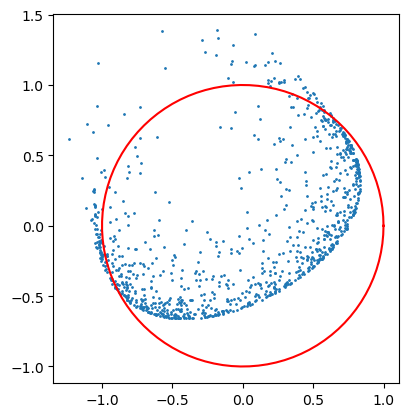

In [43]:
plot_reconstructed(autoencoder, data)
plt.plot(unitcircx,unitcircy,'r')

In [44]:
def plot_sampled(autoencoder, datapoints = 10000):
    plt.gca().set_aspect('equal')
    x_sampled = autoencoder.sample(datapoints)
    x_sampled = x_sampled.to('cpu').detach().numpy()
    plt.plot(x_sampled[:,0], x_sampled[:,1],".",markersize=2)

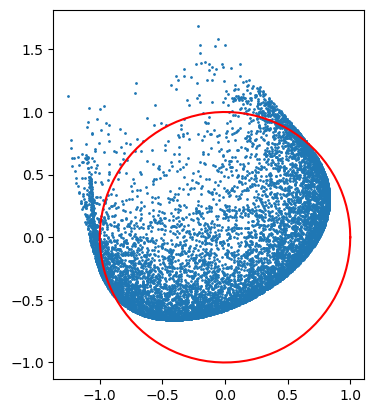

In [45]:
plot_sampled(autoencoder)
plt.plot(unitcircx,unitcircy,'r')